In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# Hyperparameters
batch_size = 64  # Number of sequences processed in parallel
block_size = 128  # Maximum sequence length for prediction
max_iters = 5000  # Maximum number of training iterations
eval_interval = 500  # Interval for evaluation during training
learning_rate = 3e-4  # Learning rate for the optimizer

# Device configuration
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Model configuration
eval_iters = 200  # Number of batches for each evaluation
d_model = 384  # Dimensionality of the model's embeddings
n_head = 6  # Number of heads in the multi-head attention mechanism
n_layer = 6  # Number of sequential transformer blocks (decoder blocks)
dropout = 0.2  # Dropout rate

# Seed for reproducibility
torch.manual_seed(888)

In [ ]:
print("Using device:", device)

Using device: cuda


In [ ]:
# Download Hemingway text training data with public access
!gdown 'https://drive.google.com/uc?id=1f2mV6FuaruKLodrONRYBLtWkna_Y0Iay'

Downloading...
From: https://drive.google.com/uc?id=1f2mV6FuaruKLodrONRYBLtWkna_Y0Iay
To: /content/hemingway_new.txt
100% 1.18M/1.18M [00:00<00:00, 90.9MB/s]


In [ ]:
# Character level text processing and data preparation
import re

# Read the file, delete \n, format spacing and return the text
def read_text(file_name):
    with open(file_name, 'r', encoding='utf-8') as file:
        text = file.read()
    text = text.replace('\n', ' ')
    text = re.sub(' +', ' ', text)
    text = re.sub(r'\s+([.,;:])', r'\1', text)
    return text

# Create mappings from characters to integers and vice versa
def create_mappings(text):
    characters = sorted(set(text))
    stoi = {char: idx for idx, char in enumerate(characters)}
    itos = {idx: char for idx, char in enumerate(characters)}
    vocab_size = len(characters)  # Calculate the vocabulary size
    return stoi, itos, vocab_size

# Reading and processing the text
text = read_text('hemingway_new.txt')
stoi, itos, vocab_size = create_mappings(text)

# Encode and decode lambda functions
encode = lambda s: [stoi[c] for c in s]  # Encoder
decode = lambda l: ''.join([itos[i] for i in l])  # Decoder

# Creating the data tensor
data = torch.tensor(encode(text), dtype=torch.long)

# Splitting the data into training and validation sets
n = int(0.9 * len(data))
train_data, val_data = data[:n], data[n:]

In [ ]:
import numpy as np

def get_batch(data_partition):
    """
    Fetch a mini-batch of data containing inputs (x) and targets (y).
    The data_partition argument determines whether to fetch from training or validation data.
    """

    # Choose the data based on the provided partition: training or validation
    data = train_data if data_partition == 'train' else val_data
    # Random selection of indices for batch_size data points
    indices = np.random.choice(len(data) - block_size, size=batch_size, replace=False)
    # Gather input data chunks of block_size length at selected indices
    x_batch = [data[idx:idx + block_size] for idx in indices]
    # Gather target data, which is offset by one from the inputs
    y_batch = [data[idx + 1:idx + 1 + block_size] for idx in indices]
    # Stack the input and target batches and move them to the specified device
    x_batch, y_batch = torch.stack(x_batch).to(device), torch.stack(y_batch).to(device)
    # The shape of x_batch and y_batch is (batch_size, block_size)
    return x_batch, y_batch

In [ ]:
@torch.no_grad()
def estimate_loss(model):
    """
    Evaluate the model's loss on both training and validation sets without gradient updates.
    The function calculates the mean loss for each set and returns these values.
    """
    results = {}
    # Evaluate model performance in a non-training context
    model.eval()

    # Loop over both training and validation data sets
    for partition in ['train', 'val']:
        # Initialize a tensor to store losses for each iteration
        loss_values = torch.zeros(eval_iters, dtype=torch.float32, device=device)
        for i in range(eval_iters):
            # Obtain a batch of data
            x_batch, y_batch = get_batch(partition)
            # Compute the model's output and loss for the batch
            logits, batch_loss = model(x_batch, y_batch)
            # Store the computed loss
            loss_values[i] = batch_loss
        # Compute and store the mean loss for the current partition
        results[partition] = loss_values.mean()
    # Revert model to training mode
    model.train()

    return results

In [ ]:
class SelfAttentionHead(nn.Module):
    """
    Implements a single head of self-attention mechanism, particularly for a decoder
    utilizing masked self-attention to prevent future information leakage.
    """

    def __init__(self, d_head):
        super().__init__()
        # Initialize the dimensions for keys, queries, and values
        self.d_head = d_head
        self.key_transform = nn.Linear(d_model, d_head, bias=False)
        self.query_transform = nn.Linear(d_model, d_head, bias=False)
        self.value_transform = nn.Linear(d_model, d_head, bias=False)

        # Lower triangular matrix to apply masked attention
        self.register_buffer('mask', torch.tril(torch.ones(block_size, block_size)))

        # Dropout layer for attention weights
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        batch_size, seq_length, _ = x.shape

        # Generate keys, queries, and values for self-attention
        keys = self.key_transform(x)
        queries = self.query_transform(x)
        values = self.value_transform(x)

        # Compute the dot product attention weights
        attention_scores = torch.matmul(queries, keys.transpose(1, 2)) / (self.d_head ** 0.5)

        # Apply masking to ensure causality in decoder
        attention_scores = attention_scores.masked_fill(self.mask[:seq_length, :seq_length] == 0, float('-inf'))

        # Normalize attention scores and apply dropout
        attention_weights = self.dropout(F.softmax(attention_scores, dim=-1))

        # Compute the weighted sum of values
        attention_output = torch.matmul(attention_weights, values)
        return attention_output

class ParallelMultiHeadAttention(nn.Module):
    """
    Aggregates multiple self-attention heads, each computing a distinct aspect of the input,
    and combines their outputs.
    """

    def __init__(self, num_heads, d_head):
        super().__init__()
        # Initialize multiple attention heads
        self.heads = nn.ModuleList([SelfAttentionHead(d_head) for _ in range(num_heads)])
        # Linear layer to project the concatenated outputs back to the original dimension
        self.output_transform = nn.Linear(num_heads * d_head, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Concatenate outputs from all attention heads
        multi_head_output = torch.cat([head(x) for head in self.heads], dim=-1)
        # Project the concatenated output to d_model dimension and apply dropout
        return self.dropout(self.output_transform(multi_head_output))

In [ ]:
class FeedForwardLayer(nn.Module):
    """
    Defines a feedforward neural network layer applied at the token level.
    It consists of two linear transformations with a ReLU activation in between.
    """

    def __init__(self, d_model):
        super(FeedForwardLayer, self).__init__()
        # Define the dimensionality of the feedforward network, typically 4 times d_model
        d_ff = 4 * d_model
        # Initialize the feedforward network components
        self.linear1 = nn.Linear(d_model, d_ff)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout()

    def forward(self, x):
        """
        The forward pass of the feedforward layer.

        :param x: The input tensor.
        :return: The output of the feedforward layer.
        """
        x = self.linear1(x)  # First linear transformation
        x = self.relu(x)     # Apply ReLU non-linearity
        x = self.linear2(x)  # Second linear transformation
        x = self.dropout(x)  # Apply dropout
        return x

In [ ]:
class TransformerDecoderBlock(nn.Module):
    """
    Represents a single block within a transformer's decoder architecture,
    comprising a multi-head self-attention mechanism and a position-wise feedforward network.
    Each block applies these components in sequence, followed by layer normalization.
    """

    def __init__(self, d_model, n_head):
        super(TransformerDecoderBlock, self).__init__()
        # Determine the size of each attention head's representation
        d_head = d_model // n_head
        # Initialize the multi-head self-attention component
        self.multihead_attention = ParallelMultiHeadAttention(n_head, d_head)
        # Initialize the feedforward network component
        self.feedforward = FeedForwardLayer(d_model)
        # Layer normalization components after the self-attention and feedforward network
        self.norm_layer1 = nn.LayerNorm(d_model)
        self.norm_layer2 = nn.LayerNorm(d_model)

    def forward(self, x):
        """
        Processes input through one decoder block, including self-attention and feedforward network.

        :param x: Input tensor to the decoder block.
        :return: Output tensor of the decoder block.
        """
        # Apply multi-head self-attention followed by layer normalization with residual connection
        attention_output = self.multihead_attention(x)
        x = self.norm_layer1(x + attention_output)
        # Apply the feedforward network followed by layer normalization with residual connection
        feedforward_output = self.feedforward(x)
        x = self.norm_layer2(x + feedforward_output)
        return x

In [ ]:
class GPTModel(nn.Module):
    """
    A simplified version of the GPT model, incorporating token and position embeddings,
    followed by a sequence of transformer decoder blocks, and concluding with a linear
    layer to produce logits for next token prediction.
    """
    def __init__(self):
        super(GPTModel, self).__init__()
        # Initialize the embedding tables for tokens and positions
        self.token_embeddings = nn.Embedding(vocab_size, d_model)
        self.position_embeddings = nn.Embedding(block_size, d_model)
        # Sequentially stack decoder blocks to form the transformer's body
        self.decoder_blocks = nn.Sequential(*[TransformerDecoderBlock(d_model, n_head) for _ in range(n_layer)])
        # Final layer normalization
        self.final_norm = nn.LayerNorm(d_model)
        # Linear transformation to project the output to the vocabulary size
        self.output_linear = nn.Linear(d_model, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape  # Batch size and sequence length

        # Embed tokens and positions
        token_emb = self.token_embeddings(idx)
        position_emb = self.position_embeddings(torch.arange(T, device=idx.device))

        # Combine token and position embeddings
        x = token_emb + position_emb.unsqueeze(0)

        # Process the input through the decoder blocks
        x = self.decoder_blocks(x)

        # Apply the final normalization and project to vocabulary size
        x = self.final_norm(x)
        logits = self.output_linear(x)

        # Calculate loss if targets are provided
        loss = None
        if targets is not None:
            logits_flattened = logits.view(B * T, -1)
            targets_flattened = targets.view(B * T)
            loss = F.cross_entropy(logits_flattened, targets_flattened)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        """
        Generates new tokens given a context.

        :param idx: Tensor of shape (B, T) containing token indices.
        :param max_new_tokens: Maximum number of new tokens to generate.
        :return: Tensor of shape (B, T + max_new_tokens) with the original and new tokens.
        """
        self.eval()  # Set the model to evaluation mode
        for _ in range(max_new_tokens):
            # Handle the context window limitation
            idx_cond = idx[:, -block_size:]

            # Predict the next token
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :]  # Focus on the logits for the last predicted token
            probs = F.softmax(logits, dim=-1)  # Convert logits to probabilities

            # Sample the next token from the probability distribution
            next_token = torch.multinomial(probs, 1)
            idx = torch.cat([idx, next_token], dim=1)  # Append the new token to the sequence

        self.train()  # Revert to training mode
        return idx

In [ ]:
class EarlyStoppingMechanism:
    """
    Implements early stopping to halt training when validation loss ceases to decrease significantly.
    """

    def __init__(self, tolerance=5, min_delta=0):
        """
        Initializes the early stopping parameters.

        :param tolerance: The number of epochs with no significant improvement after which training will be stopped.
        :param min_delta: The minimum relative change in validation loss considered as an improvement.
        """
        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0  # Counter for epochs without significant improvement
        self.early_stop = False  # Indicates whether to stop the training

    def __call__(self, train_loss, validation_loss):
        """
        Evaluates whether the training should stop early based on the recent trend in validation loss.

        :param train_loss: The current training loss.
        :param validation_loss: The current validation loss.
        """
        relative_improvement = (validation_loss - train_loss) / train_loss

        # Check if the improvement is less than the minimum delta
        if relative_improvement > self.min_delta:
            # Increment the counter if there is no significant improvement
            self.counter += 1
            # Trigger early stopping if the counter exceeds the tolerance threshold
            if self.counter >= self.tolerance:
                self.early_stop = True
        else:
            # Reset counter if there is significant improvement
            self.counter = 0

In [ ]:
import torch.optim as optim

# Initialize the GPT-like model and move it to the specified device
model = GPTModel().to(device)

# Calculate and display the total number of trainable parameters in the model
num_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters in the model: {num_params}")

# Set up the optimizer with the AdamW algorithm
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

# Define a learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

# Initialize the early stopping mechanism
early_stopping = EarlyStoppingMechanism(tolerance=1, min_delta=0.2)

# Training loop
for iteration in range(max_iters):
    # Periodically evaluate the model on training and validation sets
    if iteration % eval_interval == 0 or iteration == max_iters - 1:
        # Adjust the learning rate based on the scheduler
        if iteration:
            scheduler.step()

        # Estimate the loss on training and validation datasets
        evaluation_losses = estimate_loss(model)
        print(f"Step {iteration}: Train Loss: {evaluation_losses['train']:.4f}, Validation Loss: {evaluation_losses['val']:.4f}")

        # Check for early stopping
        early_stopping(evaluation_losses['train'], evaluation_losses['val'])
        if early_stopping.early_stop:
            print(f"Early stopping triggered at iteration {iteration}")
            break

    # Get a batch of training data
    xb, yb = get_batch('train')

    # Forward pass to calculate the loss
    logits, loss = model(xb, yb)

    # Backward pass to calculate gradients
    optimizer.zero_grad()
    loss.backward()

    # Update model parameters
    optimizer.step()

Number of parameters in the model: 10762078
Step 0: Train Loss: 4.8206, Validation Loss: 4.8253
Step 500: Train Loss: 1.6364, Validation Loss: 1.5538
Step 1000: Train Loss: 1.3689, Validation Loss: 1.3352
Step 1500: Train Loss: 1.2590, Validation Loss: 1.2603
Step 2000: Train Loss: 1.1875, Validation Loss: 1.2183
Step 2500: Train Loss: 1.1388, Validation Loss: 1.1942
Step 3000: Train Loss: 1.0966, Validation Loss: 1.1750
Step 3500: Train Loss: 1.0634, Validation Loss: 1.1636
Step 4000: Train Loss: 1.0368, Validation Loss: 1.1614
Step 4500: Train Loss: 1.0107, Validation Loss: 1.1531
Step 4999: Train Loss: 0.9881, Validation Loss: 1.1466


In [ ]:
# Initialize the generation context with an empty token
initial_context = torch.zeros((1, 1), dtype=torch.long, device=device)

# Generate a sequence of up to 1000 tokens from the model starting with the initial context
generated_sequence_long = model.generate(initial_context, max_new_tokens=1000)
# Convert the generated token IDs to text
generated_text_long = decode(generated_sequence_long[0].tolist())
print(generated_text_long)

# Generate a shorter sequence of up to 100 tokens for saving to a file
#generated_sequence_short = model.generate(initial_context, max_new_tokens=100)
# Convert the generated token IDs to text
#generated_text_short = decode(generated_sequence_short[0].tolist())

# Save the shorter generated text to a file
with open('fake_hemingway.txt', 'w', encoding='utf-8') as file:
    file.write(generated_text_long)

 very still have a grass, Madame Fontan. In the first ward up. I am in the eighty - first way. They wouldnt the fire in a while to move deserted under the races. Every one more was interested on it in the way out they did like to see them off as sun each quickly. It was all right. I doesnt get gray any way to Milan for a whisky. Catherine said, cH Nothing. He stood up. We would not get the seat. There were a lovely many covered man, cold working like a sort of place and shot showing smoking at the muleta if the water mother said. He was in the rain and he was big road. Since it raining forward on the quail. He was tcpicador and smiled at him as he looked so hundred and left the Manuel, dear from the hill - tight / Macomber said. He waved to him up again, and Nick. Zurito sat at his table. 5 Fontan had a sew her. The wet and put up across the bull, who ran heard his coat had been keeping under hands to the trees and one but he would be defised to which he shot against the porch coffee. 

In [ ]:
torch.save(model.state_dict(), 'gpt.pt')

# Model Evaluation: Quantitative Metrics

In [ ]:
!pip install rouge

In [ ]:
import nltk
nltk.download('punkt')
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import sentence_bleu
from rouge import Rouge
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Lexical Diversity (NLTK)

In [ ]:
# Lexical Diversity using NLTK
import nltk
from nltk.tokenize import word_tokenize

# Function to calculate lexical diversity of a text
def lexical_diversity(text):
    tokens = word_tokenize(text)
    unique_words = set(tokens)
    return len(unique_words) / len(tokens)

# Function to load text from a file
def load_text(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return file.read()

# Path to the text file
candidate_text_path = 'fake_hemingway.txt' # Model-generated Hemingway texts

# Example text
reference_text = text
candidate_text = load_text(candidate_text_path)

reference_diversity_score = lexical_diversity(reference_text)
candidate_text_diversity_score = lexical_diversity(candidate_text)
print(f"Lexical Diversity (Training): {reference_diversity_score}")
print(f"Lexical Diversity (Generated): {candidate_text_diversity_score}")

Lexical Diversity (Training): 0.05287994789426468
Lexical Diversity (Generated): 0.6103896103896104


## Sentence Complexity (SpaCy)

In [ ]:
# Sentence Complexity using SpaCy
# Sentence complexity can be gauged by analyzing the average sentence length or the use of complex syntactic structures

import spacy

def average_sentence_length(text):
    nlp = spacy.load('en_core_web_sm')
    # Increase the max length of text that the nlp object will accept
    nlp.max_length = 1500000  # Adjust this number based on text length and available memory
    doc = nlp(text)
    sentences = list(doc.sents)
    total_length = sum(len(sentence) for sentence in sentences)
    return total_length / len(sentences)

# Example text
reference_sentence_len = average_sentence_length(reference_text)
candidate_sentence_len = average_sentence_length(candidate_text)
print(f"Average Sentence Length (Train): {reference_sentence_len}")
print(f"Average Sentence Length (Generated): {candidate_sentence_len}")

Average Sentence Length (Train): 11.486417385746245
Average Sentence Length (Generated): 11.7


## Parts of Speech (POS) Usage Frequency

In [ ]:
# POS frequency

import spacy

def pos_frequency(text):
    try:
        nlp = spacy.load('en_core_web_sm')
        nlp.max_length = len(text) + 100  # Small buffer to exceed the text length
        doc = nlp(text)
        pos_counts = doc.count_by(spacy.attrs.POS)
        return {doc.vocab[key].text: value for key, value in pos_counts.items()}
    except Exception as e:
        print(f"Error processing text: {e}")
        return {}

# Get POS frequencies
reference_frequency = pos_frequency(reference_text)
candidate_frequency = pos_frequency(candidate_text)

# Function to print POS counts
def print_pos_counts(pos_counts):
    for pos, count in sorted(pos_counts.items()):
        print(f"{pos}: {count}")

# Print POS frequencies
print("Reference Text POS Frequencies:")
print_pos_counts(reference_frequency)
print("\nCandidate Text POS Frequencies:")
print_pos_counts(candidate_frequency)

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


Reference Text POS Frequencies:
ADJ: 11374
ADP: 21258
ADV: 11944
AUX: 13706
CCONJ: 8141
DET: 21570
INTJ: 1402
NOUN: 32907
NUM: 2818
PART: 5752
PRON: 32237
PROPN: 9597
PUNCT: 41303
SCONJ: 4121
SPACE: 1
SYM: 146
VERB: 33158
X: 152

Candidate Text POS Frequencies:
ADJ: 11
ADP: 28
ADV: 8
AUX: 14
CCONJ: 8
DET: 24
NOUN: 33
NUM: 4
PART: 6
PRON: 27
PROPN: 9
PUNCT: 27
SCONJ: 3
SPACE: 1
VERB: 31


In [ ]:
# Calculate frequency %
def print_pos_percentages(pos_counts):
    total_pos = sum(pos_counts.values())
    pos_percentages = {pos: (count / total_pos) * 100 for pos, count in pos_counts.items()}
    for pos, percentage in sorted(pos_percentages.items()):
        print(f"{pos}: {percentage:.2f}%")

# Define POS counts for reference and candidate texts with POS tags in dictionaries
reference_counts = {
    "ADJ":11374,"ADP": 21258,"ADV": 11944,"AUX": 13706,"CCONJ": 8141,
    "DET": 21570,"INTJ": 1402,"NOUN": 32907,"NUM": 2818,"PART": 5752,
    "PRON": 32237,"PROPN": 9597,"PUNCT": 41303,"SCONJ": 4121,"SPACE": 1,
    "SYM": 146,"VERB": 33158,"X": 152
}
candidate_counts = {
    "ADJ":11,"ADP": 22,"ADV": 12,"AUX": 18,"CCONJ": 4,
    "DET": 23,"INTJ": 1,"NOUN": 29,"NUM": 3,"PART": 11,
    "PRON": 29,"PROPN": 12,"PUNCT": 40,"SCONJ": 2,"SPACE": 1,
    "SYM": 0,"VERB": 28,"X": 0
}

# Print POS percentages for reference and candidate texts
print("Reference Text POS Percentages:")
print_pos_percentages(reference_counts)
print("\nCandidate Text POS Percentages:")
print_pos_percentages(candidate_counts)

Reference Text POS Percentages:
ADJ: 4.52%
ADP: 8.45%
ADV: 4.75%
AUX: 5.45%
CCONJ: 3.24%
DET: 8.57%
INTJ: 0.56%
NOUN: 13.08%
NUM: 1.12%
PART: 2.29%
PRON: 12.81%
PROPN: 3.81%
PUNCT: 16.42%
SCONJ: 1.64%
SPACE: 0.00%
SYM: 0.06%
VERB: 13.18%
X: 0.06%

Candidate Text POS Percentages:
ADJ: 4.47%
ADP: 8.94%
ADV: 4.88%
AUX: 7.32%
CCONJ: 1.63%
DET: 9.35%
INTJ: 0.41%
NOUN: 11.79%
NUM: 1.22%
PART: 4.47%
PRON: 11.79%
PROPN: 4.88%
PUNCT: 16.26%
SCONJ: 0.81%
SPACE: 0.41%
SYM: 0.00%
VERB: 11.38%
X: 0.00%


### Visualization (Figure 1): Comparison of POS Frequency Distributions

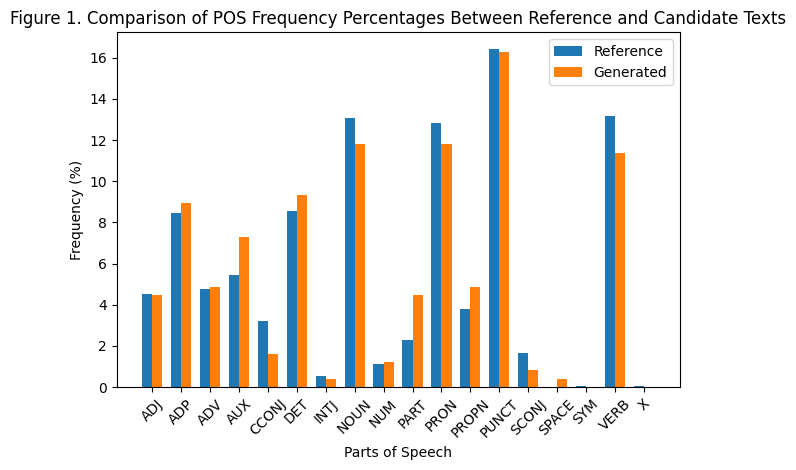

In [ ]:
import matplotlib.pyplot as plt

# Sort keys to ensure alignment between reference and candidate counts
keys = sorted(reference_counts.keys())

# Convert raw counts to percentages
total_ref = sum(reference_counts.values())
total_cand = sum(candidate_counts.values())
ref_percentages = [100 * reference_counts[k] / total_ref for k in keys]
cand_percentages = [100 * candidate_counts[k] / total_cand for k in keys]

# Create side-by-side bar plot
fig, ax = plt.subplots()
index = range(len(keys))
bar_width = 0.35

rects1 = ax.bar(index, ref_percentages, bar_width, label='Reference')
rects2 = ax.bar([p + bar_width for p in index], cand_percentages, bar_width, label='Generated')

ax.set_xlabel('Parts of Speech')
ax.set_ylabel('Frequency (%)')
ax.set_title('Figure 1. Comparison of POS Frequency Percentages Between Reference and Candidate Texts')
ax.set_xticks([p + bar_width / 2 for p in index])
ax.set_xticklabels(keys)
ax.legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## ROUGE Score (N-gram Overlap)

In [ ]:
# Load reference and candidate texts for ROUGE evaluation
def load_text(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return file.read()

# reference_text_path = text # Actual Hemingway texts
candidate_text_path = 'fake_hemingway.txt' # Model-generated Hemingway texts

reference_text = text
candidate_text = load_text(candidate_text_path)

# Split the reference text into sentences
reference_sentences = nltk.sent_tokenize(reference_text.lower())

# Choose a segment from the reference text that matches the candidate text length
# Function to calculate the start index for the reference text based on TF-IDF and cosine similarity
def find_most_similar_segment(reference_sentences, candidate_text, n_sentences):
    # Initialize the vectorizer
    vectorizer = TfidfVectorizer()
    # Create a corpus with the candidate text and all reference sentences
    corpus = [candidate_text] + reference_sentences
    # Fit and transform the corpus
    tfidf_matrix = vectorizer.fit_transform(corpus)
    # Calculate cosine similarity between the candidate text and all reference sentences
    similarities = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:]).flatten()
    # Find the index of the highest similarity score
    best_match_index = np.argmax(similarities)
    # Calculate the start index to get n_sentences around the best match
    start_index = max(0, best_match_index - n_sentences // 2)
    end_index = start_index + n_sentences
    return start_index, end_index

# Find the most similar segment of the reference text to the candidate text
n_sentences_to_compare = 100  # Can adjust this to the average number of sentences in 100 tokens
start_index, end_index = find_most_similar_segment(reference_sentences, candidate_text, n_sentences_to_compare)

# Extract the segment from the reference text
reference_segment = " ".join(reference_sentences[start_index:end_index])

# Calculate ROUGE scores using the selected segment
# rouge_scores = calculate_rouge_score(reference_segment, candidate_text)
rouge_seg = Rouge()
rouge_score_seg = rouge_seg.get_scores(candidate_text, reference_segment)

print(f"Selected segment from index {start_index} to {end_index} for evaluation.")
rouge_score_seg

Selected segment from index 16910 to 17010 for evaluation.


[{'rouge-1': {'r': 0.16997167138810199,
   'p': 0.42857142857142855,
   'f': 0.2434077038440809},
  'rouge-2': {'r': 0.022058823529411766,
   'p': 0.0891089108910891,
   'f': 0.035363454579224546},
  'rouge-l': {'r': 0.16147308781869688,
   'p': 0.40714285714285714,
   'f': 0.23123731844854334}}]

In [ ]:
# ROUGE scores without segmenting reference text
rouge = Rouge()
rouge_score = rouge.get_scores(candidate_text, reference_text)

print(f"Using full reference text without segments for evaluation.")
rouge_score

Using full reference text without segments for evaluation.


[{'rouge-1': {'r': 0.009507946422374904,
   'p': 0.9785714285714285,
   'f': 0.01883290928771348},
  'rouge-2': {'r': 0.0014353442651472315,
   'p': 0.6534653465346535,
   'f': 0.002864396805425585},
  'rouge-l': {'r': 0.009507946422374904,
   'p': 0.9785714285714285,
   'f': 0.01883290928771348}}]

## METEOR Score

In [ ]:
from nltk.translate.meteor_score import meteor_score
from nltk.tokenize import word_tokenize
nltk.download('wordnet')

# Tokenize the segmented reference text and wrap it in a list (instead of string)
reference_seg = [word_tokenize(reference_segment)]

# Tokenize the candidate text and keep it as a string
candidate_text = load_text(candidate_text_path)
candidate_texts = word_tokenize(candidate_text)

# Calculate METEOR score
meteor_result = meteor_score(reference_seg, candidate_texts)

print(f"Selected segment from index {start_index} to {end_index} for evaluation.")
print(f"METEOR Score: {meteor_result}")

[nltk_data] Downloading package wordnet to /root/nltk_data...


Selected segment from index 16910 to 17010 for evaluation.
METEOR Score: 0.08585715633550334


## BERT Score

In [ ]:
!pip install bert_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 1.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manyli

In [ ]:
from bert_score import score as bert_score

def calculate_bert_score(references, candidates, lang='en'):
    """
    Calculate BERTScore between lists of reference and candidate texts.
    """
    P, R, F1 = bert_score(candidates, references, lang=lang, rescale_with_baseline=True)
    return P.mean().item(), R.mean().item(), F1.mean().item()

# Calculate BERT score
P, R, F1 = calculate_bert_score([reference_segment], [candidate_text])
print(f"BERTScore Precision: {P}, Recall: {R}, F1 Score: {F1}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERTScore Precision: -0.23469866812229156, Recall: -0.3318585455417633, F1 Score: -0.28170245885849
